In [1]:
import torch
from torchvision import models

vgg19 = models.vgg19(pretrained = True).features
print(vgg19)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [2]:
for param in vgg19.parameters():
    param.requires_grad_(False)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
vgg19.to(device)

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
from PIL import Image
from torchvision import transforms as T

def procImg(img_path, max_size = 500):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size

    else:
        size = max(image.size)
    
    imgTransforms = T.Compose([
                    T.Resize(size), 
                    T.ToTensor(), 
                    T.Normalize(mean = [0.485, 0.456, 0.406], 
                                std = [0.229, 0.224, 0.225])
    ])
    
    image = imgTransforms(image).unsqueeze(0)

    return image

contentProc = procImg('spiderman.jpg')
styleProc = procImg('style10.jpg')

contentProc = contentProc.to(device)
styleProc = styleProc.to(device)

print('Processed Content Shape: ', contentProc.shape)
print('Processed Style Shape: ', styleProc.shape)

Processed Content Shape:  torch.Size([1, 3, 500, 888])
Processed Style Shape:  torch.Size([1, 3, 500, 765])


Deprocessed Content Shape:  (500, 888, 3)
Deprocessed Style Shape:  (500, 765, 3)


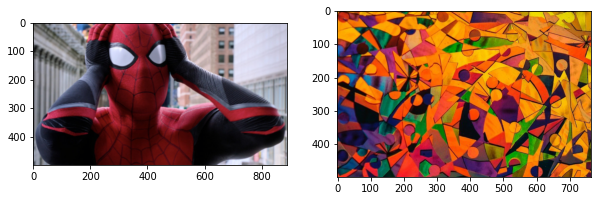

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def deprocImg(tensor):
    image = tensor.to('cpu').clone()
    image = image.numpy()
    image = image.squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = image.clip(0, 1)

    return image

contentDeproc = deprocImg(contentProc)
styleDeproc = deprocImg(styleProc)

print('Deprocessed Content Shape: ', contentDeproc.shape)
print('Deprocessed Style Shape: ', styleDeproc.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(contentDeproc)
ax2.imshow(styleDeproc)

In [6]:
def featureExtract(image, model):
    layers = {
        '0':'conv1_1', 
        '5':'conv2_1', 
        '10':'conv3_1', 
        '19':'conv4_1', 
        '21':'conv4_2', 
        '28':'conv5_1'
    }

    x = image
    features = {}
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    
    return features

contentFeatures = featureExtract(contentProc, vgg19)
styleFeatures = featureExtract(styleProc, vgg19)

In [7]:
def gramMatrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h*w)
    gram = torch.mm(tensor, tensor.t())

    return gram

styleGrams = {layer : gramMatrix(styleFeatures[layer]) for layer in styleFeatures}

In [8]:
def contentLoss(target_conv4_2, content_conv4_2):
    loss = torch.mean((target_conv4_2 - content_conv4_2)**2)

    return loss

styleWeights = {'conv1_1':1.0, 
             'conv2_1':0.75, 
             'conv3_1':0.2, 
             'conv4_1':0.2, 
             'conv5_1':0.2}

def styleLoss(styleWeights, targetFeatures, styleGrams):
    loss = 0

    for layer in styleWeights:
        target_f = targetFeatures[layer]
        targetGram = gramMatrix(target_f)
        styleGram = styleGrams[layer]
        b, c, h, w = target_f.shape
        layerLoss = styleWeights[layer] * torch.mean((targetGram - styleGram)**2)
        loss += layerLoss/(c*h*w)

    return loss

target = contentProc.clone().requires_grad_(True).to(device)
targetFeatures= featureExtract(target, vgg19)
print('Content Loss: ', contentLoss(targetFeatures['conv4_2'], contentFeatures['conv4_2']))
print('Style Loss: ', styleLoss(styleWeights, targetFeatures, styleGrams))

Content Loss:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style Loss:  tensor(1267.0009, device='cuda:0', grad_fn=<AddBackward0>)


In [9]:
from torch import optim

optimiser = optim.Adam([target], lr = 0.05)
alpha, beta, epochs, tracker = 1, 1e5, 5000, 500

def totalLoss(contentLoss, styleLoss, alpha, beta):
    loss = alpha*contentLoss + beta*styleLoss

    return loss

In [10]:
results = []

for i in range(epochs):
    targetFeatures = featureExtract(target, vgg19)
    c_loss = contentLoss(targetFeatures['conv4_2'], contentFeatures['conv4_2'])
    s_loss = styleLoss(styleWeights, targetFeatures, styleGrams)
    t_loss = totalLoss(c_loss, s_loss, alpha, beta)

    optimiser.zero_grad()
    t_loss.backward()
    optimiser.step()

    if i % tracker == 0:
        print('Epoch #{}, Loss: {:.2f}'.format(i, t_loss))
        results.append(deprocImg(target.detach()))

Epoch #0, Loss: 126700088.00
Epoch #500, Loss: 254478.39
Epoch #1000, Loss: 72648.19
Epoch #1500, Loss: 2567506.25
Epoch #2000, Loss: 63713.40
Epoch #2500, Loss: 49005.37
Epoch #3000, Loss: 3056688.50
Epoch #3500, Loss: 50788.58
Epoch #4000, Loss: 42932.04
Epoch #4500, Loss: 85321.74


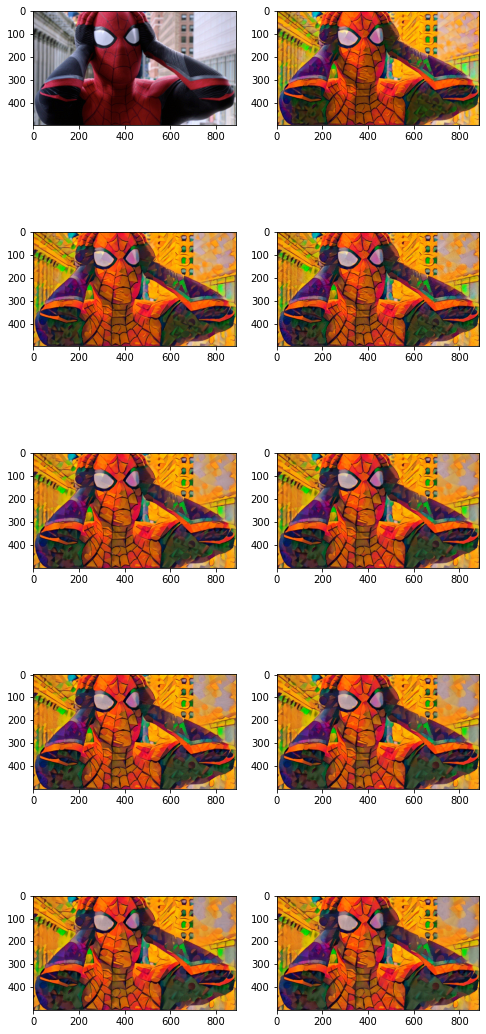

In [11]:
plt.figure(figsize = (8, 40))

for i, image in enumerate(results):
    plt.subplot(10, 2, i+1)
    plt.imshow(image)
plt.show()

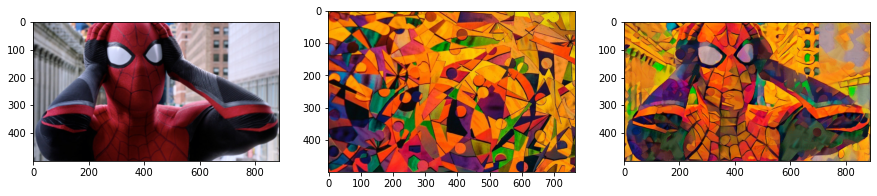

In [12]:
targetCopy = deprocImg(target.detach())
contentCopy = deprocImg(contentProc)
styleCopy = deprocImg(styleProc)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
ax1.imshow(contentCopy)
ax2.imshow(styleCopy)
ax3.imshow(targetCopy)